In [ ]:
#http://qwertytuiyytredsdafghewquroi.ru

In [4]:
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 353.7/353.7 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.4.0-py2.py3-none-any.whl size=350809 sha256=53ab3d9e3ea38295aeb676a4e795dea15d7c23557d35097f2e4b52a65554e469
  Stored in directory: /root/.cache/pip/wheels/79/29/1c/234cae4632803c2ba4a76a71a679eb1383cf590775714e2a21
Successfully built emoji


In [1]:
import pandas as pd
import json
import numpy as np
import requests
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/data_science/datasets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Сбор данных

Было выбрано сообщество реальный футбол (https://vk.com/footballru), потому что оно крупное и живое. Дальше идет код сбора данных через апи вк, но он к сожалению не работает в колабе, потому что колаб использует айпи адреса гугла, а вк банит айпишники отличающиеся от оригинального (на котором было сделано приложение)

In [7]:
vk_config = {"token": "vk1.a.iOemQfb8zDgtDuviwWinaqZdPzKcfZZ-iUMFct_ayQWdcuRayrbDRkoZeEPFxZIK0Ibuw5msV2gNouzuMii5ZxB4VBn3mb_FpTqk5JL7P8pFq2yR_bUqq2cUeBCEDz1tDFPh_Jgpldm4RVGjodEuKVWsrYhopH08LXbYQSEekSkV2sxzcVG8ohdDSaid_n19a2tp-1cAVyCAaUu7BLWkeQ",
             "client_id": "51661257", #ID приложения
             "version": "5.124",
             "domain": "https://api.vk.com/method/"}

In [8]:
import time


def get_group_id(short_name, token, version):
    url = f'https://api.vk.com/method/utils.resolveScreenName'
    params = {
        'screen_name': short_name,
        'access_token': token,
        'v': version
    }
    response = requests.get(url, params=params).json()
    return -response['response']['object_id']


def get_posts(gr_id, count, offset):
    response = requests.get(
        "https://api.vk.com/method/wall.get",
        params={
            'owner_id': gr_id,
            "access_token": vk_config["token"],
            "v": vk_config["version"],
            "count": count,
            "offset": offset
        }
    )
    return response.json()

def get_comments(gr_id, post_id, token, version, ct):
    tmp_comments = []

    count = 100
    offset = 0

    while True:
        response = requests.get(
            'https://api.vk.com/method/wall.getComments',
            params={
                'owner_id': gr_id,
                'post_id': post_id,
                'access_token': token,
                'v': version,
                'count': min(ct, count),
                'offset': offset
            }
        ).json()

        ct -= count

        if 'response' not in response or not response['response']['items']:
            break

        tmp_comments.extend(response['response']['items'])
        offset += count

        time.sleep(0.5)

    return tmp_comments

In [9]:
group_id = get_group_id('footballru', vk_config['token'], vk_config['version'])
print(group_id)

all_posts = []


for i in range(0, 1000, 100):
    response = get_posts(group_id, 100, i)
    if 'response' in response:
        all_posts.extend(response['response']['items'])
    else:
        print("Error in response: ", response)
        break

filtered_posts = []
for post in all_posts:
    filtered_post = {
        "likes": post.get('likes', {}).get('count', 0),
        "marked_as_ads": post.get('marked_as_ads', 0),
        "date": post.get('date', ''),
        "text": post.get('text', '')
    }
    filtered_posts.append(filtered_post)

KeyError: ignored

In [ ]:
all_comments = []

for post in all_posts:
    response = get_comments(group_id, post.get('id', ''), vk_config['token'],
                            vk_config['version'], post.get('comments', {}).get('count', 0))
    all_comments.extend(response)

filtered_comments = []
for comm in all_comments:
    filtered_comment = {
        "text": comm.get('text', '')
    }
    filtered_comments.append(filtered_comment)

In [ ]:
with open('posts.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=filtered_posts[0].keys())
    writer.writeheader()
    writer.writerows(filtered_posts)

with open('comments.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.DictWriter(file, fieldnames=filtered_comments[0].keys())
    writer.writeheader()
    writer.writerows(filtered_comments)

# Работа с данными

In [3]:
dfp = pd.read_csv(way + 'posts.csv')
dfc = pd.read_csv(way + 'comments.csv')

In [4]:
dfp['marked_as_ads'].sum()

7

In [5]:
dfp['date'] = pd.to_datetime(dfp['date'], unit='s')

In [6]:
dfp.iloc[999]

likes                                                         1479
marked_as_ads                                                    0
date                                           2023-05-05 19:07:15
text             Лучшие 💪 \n \nКоманда сезона АПЛ по версии EA ...
Name: 999, dtype: object

In [7]:
dfp.drop(dfp[dfp['marked_as_ads'] == 1].index, inplace=True)
dfp.drop(columns='marked_as_ads', inplace=True)

In [8]:
dfp.sample(5)

,likes,date,text
335,2413,2023-05-25 18:32:10,Стамбул преображается к финалу ЛЧ 😍\n\n#vkfoot...
777,2457,2023-05-12 17:00:03,Эль-Класико много не бывает! 😍\n\n#vkfootball
412,1940,2023-05-23 11:00:04,А как вам такое? Неожиданно! 😳\n\n#vkfootball
65,11674,2023-06-03 16:09:45,«Ман Сити» побеждает в финале Кубка Англии 🇬🇧\...
805,1142,2023-05-11 18:00:01,🌱 «Ливерпуль» и «Тоттенхэм» — самые экологичны...


In [9]:
dfc.sample(5)

,text
3762,Рома
21683,Реал играл нормально только во втором тайме \n...
6320,Боруссия спецом уже каторый раз спецом сливают...
7672,Көтке кірмеш
18370,Свиньи- болельщики выбежали на стадион


In [10]:
df = pd.concat([dfc, dfp['text']], ignore_index=True)
df.drop(columns=[0], inplace=True)

In [11]:
df = df.dropna()

In [12]:
df.shape

(24496, 1)

Проводим токенизацию, затем удаляем стоп слова и знаки препинания, т.к. нам нужны слова. разбор предложений мы не трогаем

In [13]:
df['text'] = df['text'].astype(str)

<ipython-input-13-e72252b4a215>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].astype(str)


In [14]:
df['text'] = df['text'].apply(lambda s: emoji.replace_emoji(s, ''))

In [15]:
import nltk
import string
from nltk.corpus import stopwords
import emoji

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
df['tokenized_text'] = df['text'].apply(nltk.word_tokenize)

df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word.lower() for word in x])

In [17]:
df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word not in (string.punctuation + '...' + '\'' + '\«' + '\"' + '\'\'')])

stop_words = stopwords.words('russian')

parasites = ['это', 'а', 'ну', 'я', 'тот', 'в', 'и', 'те' ]

df['tokenized_text'] = df['tokenized_text'].apply(lambda x: [word for word in x if word not in stop_words + parasites])

In [18]:
df.sample(5)

,text,tokenized_text
19723,Состав прекрасный конечно но Вальдес выпадает ...,"[состав, прекрасный, вальдес, выпадает, топ, в..."
4054,Особенный,[особенный]
223,"По-любому понравилось бы, но к сожалению он с ...","[по-любому, понравилось, сожалению, небес, наб..."
5229,Чиквуэмека,[чиквуэмека]
6985,"Они старались, но не получилось. Обидно за ребят","[старались, получилось, обидно, ребят]"


In [19]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [20]:
import pymorphy2
from tqdm.notebook import tqdm
analyzer = pymorphy2.MorphAnalyzer()

df['tokenized_text'] = df['tokenized_text'].apply(lambda row: [analyzer.parse(token)[0].normal_form for token in row] if isinstance(row, list) else [])


In [22]:
df.sample(5)

,text,tokenized_text
7798,Боруссию обязательно надо глянуть. Надеюсь ста...,"[боруссия, обязательно, глянуть, надеяться, ст..."
5592,И не нужен с их унылой игрой,"[нужный, унылый, игра]"
12875,Думаю больше всего жду этого финала чем ЛЧ.\nС...,"[думать, ждать, финал, лч, севилльяять]"
711,"Когда Наполи отпустил Мертенса , Инсини, Кулиб...","[наполоть, отпустить, мертенс, инсинь, кулибал..."
17560,"Милан сегодня дасть жару,Леау восстановился,ка...","[милан, сегодня, дасть, жара, леау, восстанови..."


# Анализ данных

In [23]:
all_words = []
for i in df['tokenized_text'].tolist():
  all_words.extend(i)
len(all_words)

142230

In [24]:
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm

id2word = corpora.Dictionary(df['tokenized_text'].tolist())
texts = df['tokenized_text'].tolist()
corpus = [id2word.doc2bow(text) for text in texts]

In [25]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, limit=20, start=2,  step=1)

100%|██████████| 18/18 [05:16<00:00, 17.58s/it]


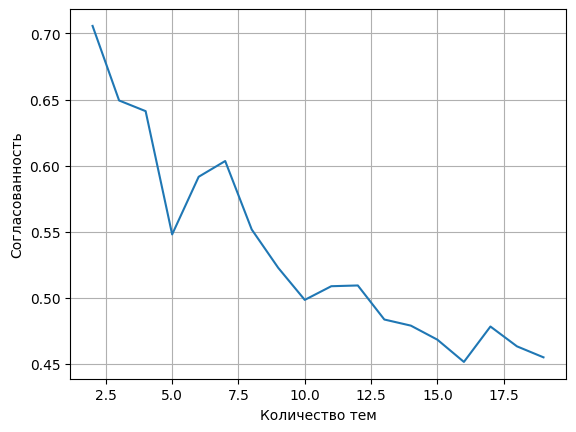

In [26]:
limit=20; start=2; step=1;
x = range(start, limit, step)

data = pd.DataFrame({
    "Количество тем": x,
    "Согласованность": coherence_values
})

sns.lineplot(x="Количество тем", y="Согласованность", data=data)
plt.grid(True)
plt.show()

0 1 2 3 4 5 6 7 8  9  10 11 12 13 14 15 16 17 18 - индекс

2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 - темы

---



In [ ]:
!pip install pandas==1.2.5

In [27]:
model_list[2].print_topics()

[(0,
  '0.030*"сити" + 0.016*"интер" + 0.013*"милан" + 0.011*"финал" + 0.010*"матч" + 0.008*"хороший" + 0.008*"лч" + 0.007*"играть" + 0.006*"год" + 0.006*"взять"'),
 (1,
  '0.015*"хороший" + 0.013*"сити" + 0.010*"реал" + 0.009*"игра" + 0.009*"сезон" + 0.008*"футбол" + 0.008*"лч" + 0.008*"игрок" + 0.008*"месси" + 0.007*"год"'),
 (2,
  '0.041*"реал" + 0.011*"барс" + 0.009*"месси" + 0.008*"судья" + 0.008*"бавария" + 0.008*"матч" + 0.005*"сегодня" + 0.005*"лч" + 0.005*"холланд" + 0.005*"нога"'),
 (3,
  '0.012*"реал" + 0.011*"играть" + 0.008*"лига" + 0.008*"лч" + 0.008*"такой" + 0.007*"месси" + 0.007*"матч" + 0.007*"админ" + 0.007*"сити" + 0.006*"выиграть"')]

In [28]:
model_list[4].print_topics()

[(0,
  '0.016*"реал" + 0.009*"игра" + 0.008*"великий" + 0.007*"лч" + 0.007*"милан" + 0.007*"финал" + 0.006*"админ" + 0.006*"зинченко" + 0.006*"матч" + 0.006*"играть"'),
 (1,
  '0.018*"барс" + 0.018*"реал" + 0.011*"играть" + 0.009*"легенда" + 0.008*"месси" + 0.008*"такой" + 0.007*"сегодня" + 0.007*"хороший" + 0.006*"неймара" + 0.006*"сити"'),
 (2,
  '0.023*"лч" + 0.015*"реал" + 0.014*"выиграть" + 0.012*"матч" + 0.009*"кубок" + 0.009*"год" + 0.008*"челси" + 0.007*"финал" + 0.007*"победа" + 0.007*"сезон"'),
 (3,
  '0.013*"гол" + 0.011*"реал" + 0.009*"так" + 0.008*"матч" + 0.008*"бавария" + 0.007*"1" + 0.007*"хороший" + 0.006*"другой" + 0.006*"забыть" + 0.005*"игра"'),
 (4,
  '0.046*"сити" + 0.036*"реал" + 0.020*"интер" + 0.011*"играть" + 0.009*"судья" + 0.009*"матч" + 0.008*"мю" + 0.008*"просто" + 0.008*"команда" + 0.007*"финал"'),
 (5,
  '0.023*"хороший" + 0.019*"месси" + 0.014*"сезон" + 0.013*"игрок" + 0.012*"сити" + 0.012*"клуб" + 0.011*"лига" + 0.009*"холланд" + 0.009*"реал" + 0.009*"

In [29]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os

In [30]:
model_ch = model_list[4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [31]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(model_ch, corpus, id2word)
LDAvis_prepared

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.023860 -0.028872       1        1  22.260327
4      0.055179  0.012948       2        1  20.281131
2      0.036674  0.052517       3        1  15.446560
1      0.046948 -0.167657       4        1  15.102250
3     -0.189709  0.019880       5        1  13.652884
0      0.074768  0.111185       6        1  13.256848, topic_info=          Term         Freq        Total Category  logprob  loglift
9         сити  1918.000000  1918.000000  Default  30.0000  30.0000
0        интер   802.000000   802.000000  Default  29.0000  29.0000
119    хороший  1156.000000  1156.000000  Default  28.0000  28.0000
408         лч  1129.000000  1129.000000  Default  27.0000  27.0000
40       месси   970.000000   970.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
140       лига    86.348461   662.991516   Topic6  -5.3862  -0.0177
375  поставить    58.712147   151.762669   Topic6  -5.7719   1.0710
638     футбол    69.566960   519.279553   Topic6  -5.6023   0.0105
49        клуб    66.584279   679.432681   Topic6  -5.6461  -0.3021
197       барс    66.193681   790.778900   Topic6  -5.6520  -0.4598

[467 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2563      4  0.950224   ......
505       2  0.064353        0
505       3  0.025741        0
505       5  0.900936        0
521       3  0.949721      0-3
...     ...       ...      ...
598       1  0.946668   эффект
1766      2  0.323604  ювентус
1766      3  0.029419  ювентус
1766      6  0.647207  ювентус
4471      6  0.990590     ясно

[1127 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 5, 3, 2, 4, 1])

тема 1 - уход Месси из клуба

тема 2 - матч манчестер сити и реала в лиге чемпионов

тема 3 - лига чемпионов

тема 4 - испанский футбол

тема 5 - голы в матчах

тема 6 - снова реал

# Анализ 2

In [32]:
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393206 sha256=41a1c0e9e2ee622c6f16540226399a19f6e1bf9cbc1d7cfa6b2d182a49a2a0e9
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [33]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
original_texts = df['text'].tolist()

results = model.predict(original_texts, k=1)
sent = []

for message, sentiment in zip(original_texts, results):
    sent.append(list(sentiment.keys())[0])

df["sentiment"] = sent


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [35]:
df.sample(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,tokenized_text,sentiment
9636,Карма нагельсман,"[карма, нагельсман]",neutral
2147,"""впереди Аль-Чтотохад""","[``, впереди, аль-чтотохад]",neutral
11586,А ещё говорят что только в РПЛ играют договорн...,"[ещё, говорить, рпл, играть, договорняк]",neutral
7002,Позорники!,[позорник],neutral
138,"Девушки не поймут, настоящую мужскую боль, Фан...","[девушка, понять, настоящий, мужской, боль, фа...",neutral


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


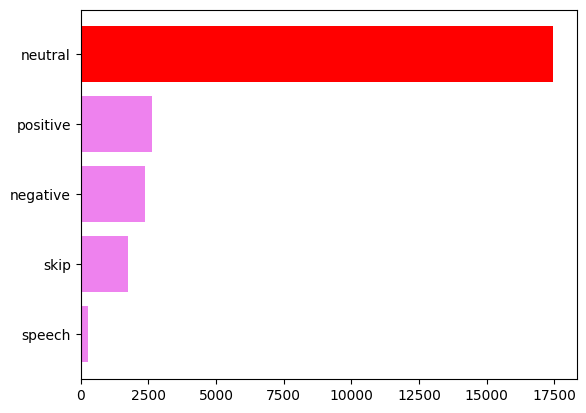

In [79]:
vis = pd.DataFrame(df['sentiment'].value_counts()).sort_values(by="count")

colors = ["violet" for _ in range(4)]+["red"]
plt.barh(y=vis.index, width=vis['count'], color=colors)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


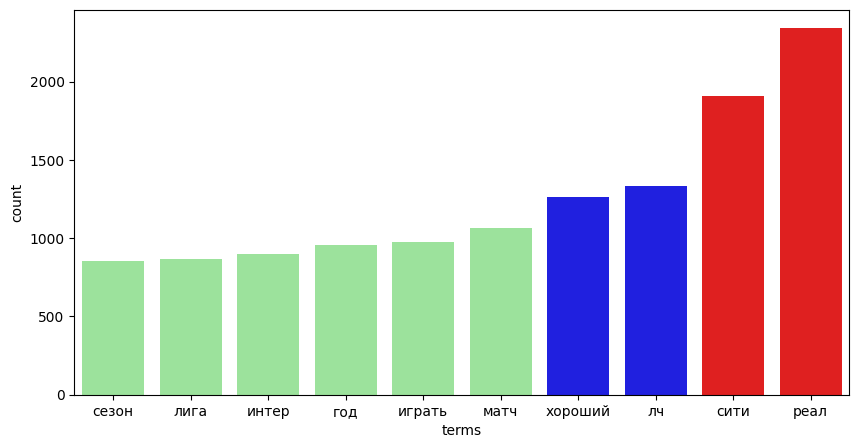

In [43]:
res = pd.DataFrame(all_words, columns=["terms"])
vis = pd.DataFrame(res["terms"].value_counts()).sort_values(by="count", ascending=False)[:10].sort_values(by="count")

colors = ['red' if i < 2 else 'blue' if i < 4 else 'lightgreen' for i in range(vis.shape[0])][::-1]

plt.figure(figsize=(10, 5))
sns.barplot(y=vis["count"], x=vis.index, palette=colors)
plt.show()


In [44]:
from collections import Counter
words = dict(Counter(all_words))
print(len(words))

17094


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [46]:
from wordcloud import WordCloud
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


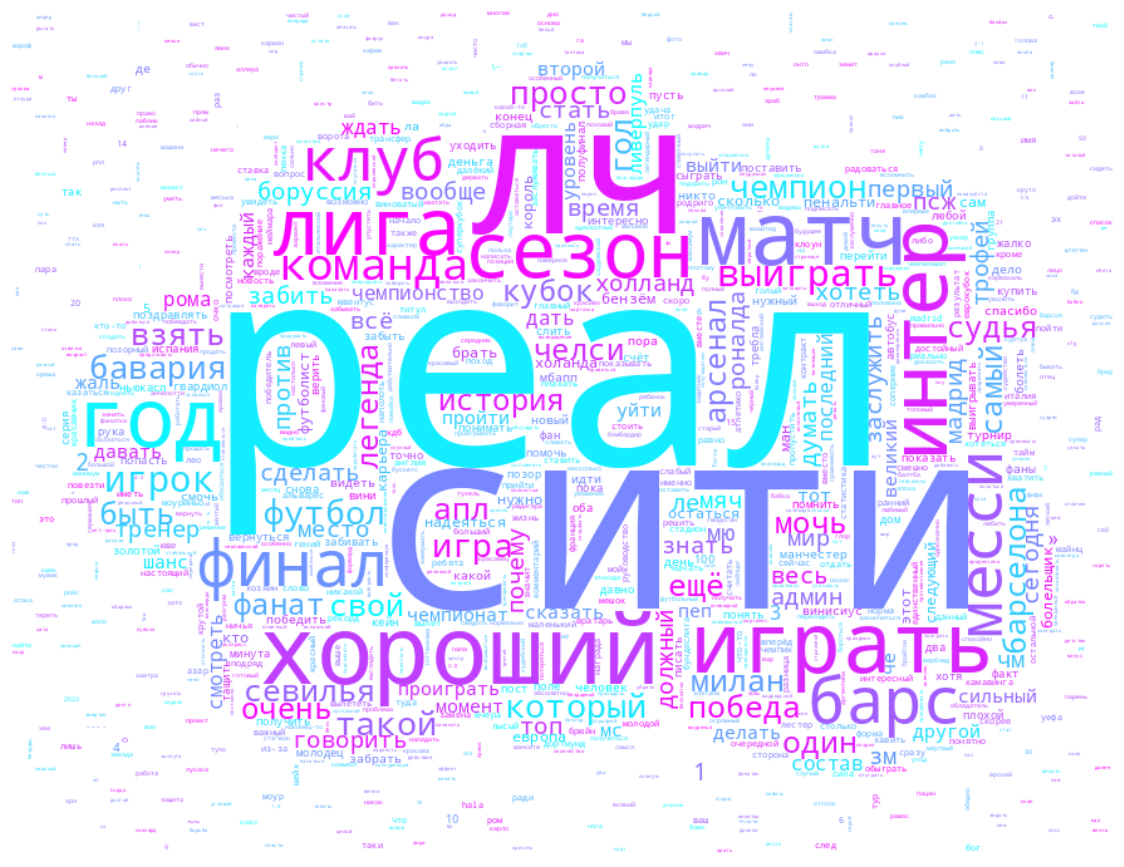

In [47]:
# генерируем маску
url = "https://www.pinclipart.com/picdir/middle/519-5194083_cloud-clipart.png"
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))

wc = WordCloud(background_color="white", max_words=2000, mask=cloud_mask, colormap="cool")
wc.generate_from_frequencies(words)

plt.figure(figsize=(15, 11))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

дальше делаем граф

In [48]:
pairs = []
for doc in df['tokenized_text'].tolist():
  if doc:
    b = list((nltk.bigrams(doc)))
    if b:
      pairs.extend(b)
len(pairs)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


118572

In [55]:
pairs = [tuple(sorted(pair)) for pair in pairs]
word_pairs = dict(Counter(pairs))
print(len(word_pairs))

80560


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
word_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 10]
print(len(word_pairs))
word_pairs[:10]

558


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('интер', 'победить', 19),
 ('гейдрид', 'рыгать', 15),
 ('каждый', 'матч', 28),
 ('аравия', 'саудовский', 30),
 ('месси', 'псж', 12),
 ('легенда', 'реал', 23),
 ('выиграть', 'реал', 51),
 ('выиграть', 'мочь', 23),
 ('болельщик', 'реал', 27),
 ('реал', 'сегодня', 13)]

In [51]:
!pip install networkx

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
from math import gcd
import networkx as nx

G = nx.Graph()
edges = word_pairs
edges[:10], len(edges)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


([('интер', 'победить', 19),
  ('гейдрид', 'рыгать', 15),
  ('каждый', 'матч', 28),
  ('аравия', 'саудовский', 30),
  ('месси', 'псж', 12),
  ('легенда', 'реал', 23),
  ('выиграть', 'реал', 51),
  ('выиграть', 'мочь', 23),
  ('болельщик', 'реал', 27),
  ('реал', 'сегодня', 13)],
 558)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


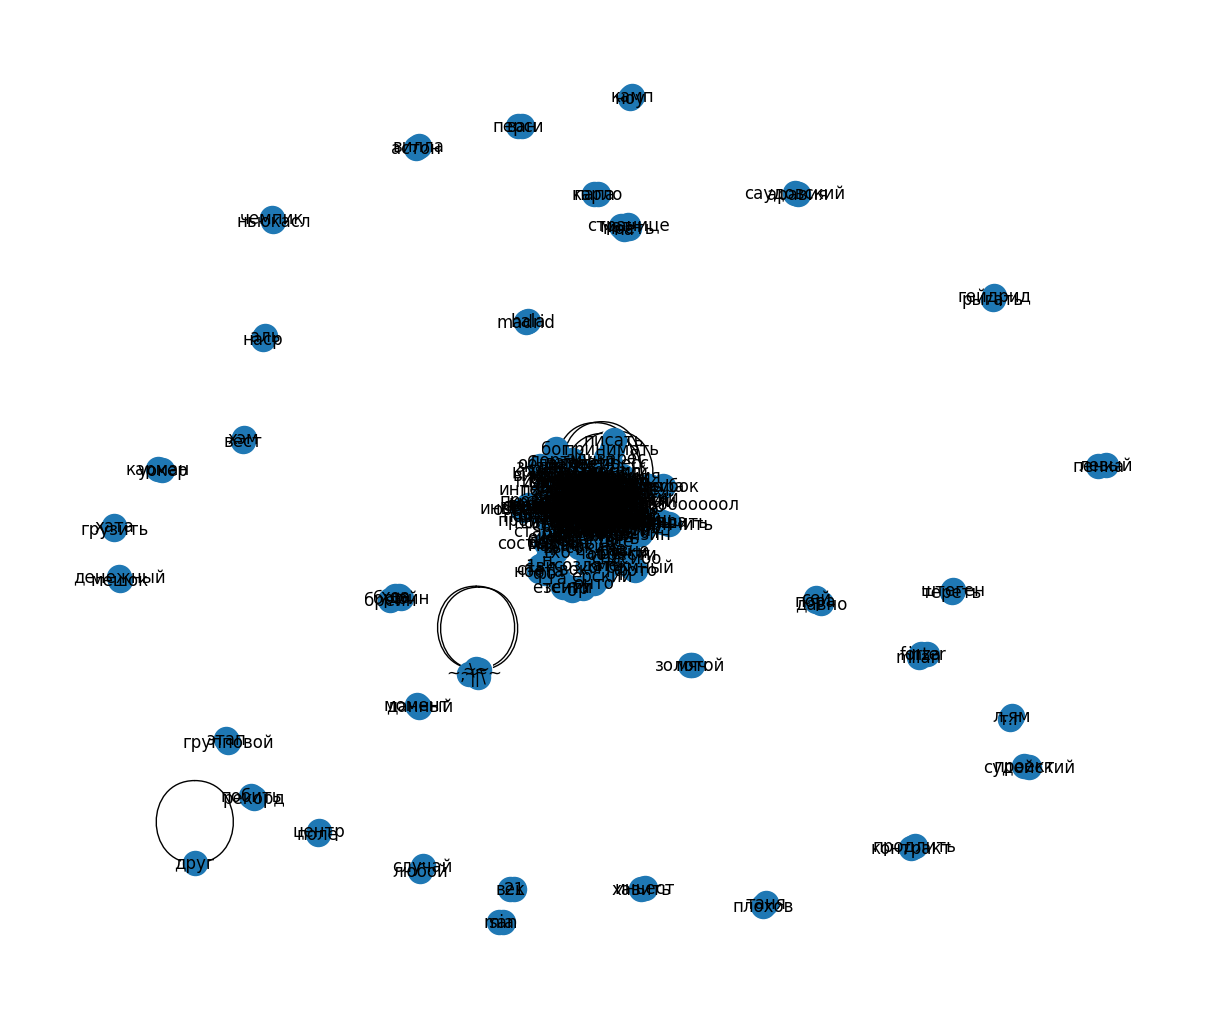

In [62]:
plt.figure(figsize=(12,10))
G.add_weighted_edges_from(edges)
labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


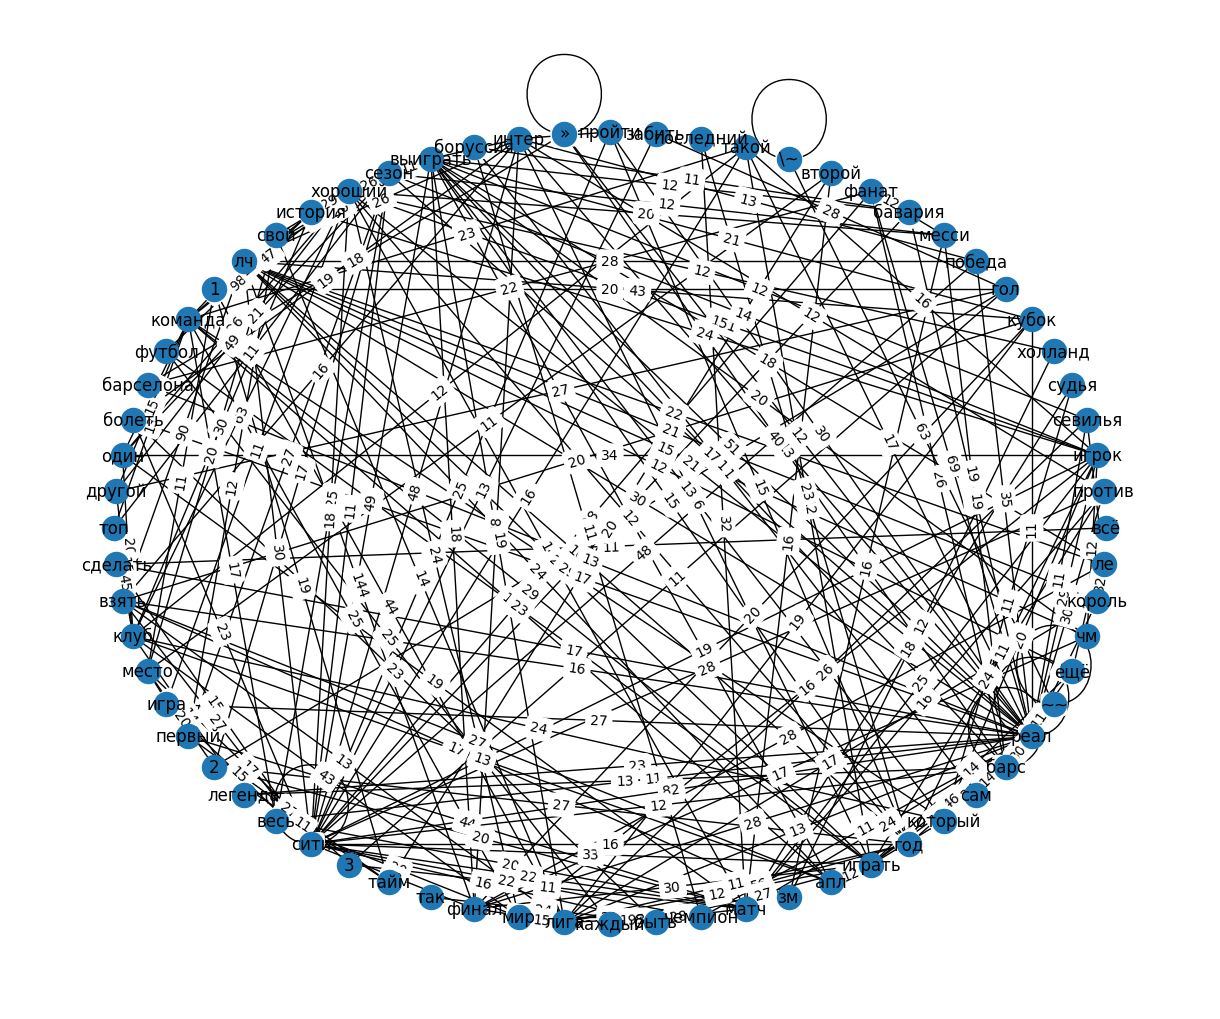

In [67]:
degree_threshold = 3

degrees = G.degree()

nodes_to_keep = [node for node, degree in degrees if degree > degree_threshold]

G_filtered = G.subgraph(nodes_to_keep)

plt.figure(figsize=(12,10))
labels_filtered = nx.get_edge_attributes(G_filtered, 'weight')
pos_filtered = nx.circular_layout(G_filtered)
nx.draw(G_filtered, pos_filtered, with_labels=True)
nx.draw_networkx_edge_labels(G_filtered, pos_filtered, edge_labels=labels_filtered)
plt.show()


In [68]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 2]
G.remove_nodes_from(remove)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [69]:
remove_edge = [pair for pair in G.edges() if pair[0] in remove and pair[1] in remove]
G.remove_edges_from(remove_edge)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [73]:
node_sizes = [deg*50 for node, deg in dict(G.degree()).items()]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Выводы: можно легко увидеть как большое тематическое сообщество деградирует к постоянным локальным обуждениям одного и того же